<a href="https://colab.research.google.com/github/ANTRIKSH-GANJOO/pytorch_research/blob/main/WithReg_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 80125752.80it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

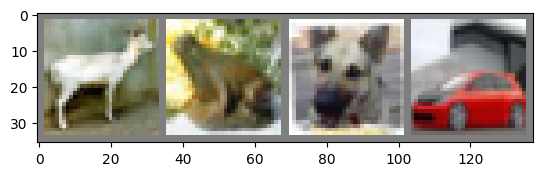

deer  frog  dog   car  


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        l1_norm = torch.norm(out,1)
        l2_norm = torch.norm(out,2)
        quotient = l1_norm / l2_norm
        hoyer_norm = quotient ** 2
        reg = hoyer_norm
        out = self.layer1(out)
        l1_norm = torch.norm(out,1)
        l2_norm = torch.norm(out,2)
        quotient = l1_norm / l2_norm
        hoyer_norm = quotient ** 2
        reg += hoyer_norm
        out = self.layer2(out)
        l1_norm = torch.norm(out,1)
        l2_norm = torch.norm(out,2)
        quotient = l1_norm / l2_norm
        hoyer_norm = quotient ** 2
        reg += hoyer_norm
        out = self.layer3(out)
        l1_norm = torch.norm(out,1)
        l2_norm = torch.norm(out,2)
        quotient = l1_norm / l2_norm
        hoyer_norm = quotient ** 2
        reg += hoyer_norm
        out = self.layer4(out)
        l1_norm = torch.norm(out,1)
        l2_norm = torch.norm(out,2)
        quotient = l1_norm / l2_norm
        hoyer_norm = quotient ** 2
        reg += hoyer_norm
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out,reg


def ResNet18():

    return ResNet(ResidualBlock)

my_net = ResNet18()

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_net.to(device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inp

In [42]:
initial_sparsity_values = []

def get_initial_activation_sparsity(name):
    def hook(model, input, output):
        total_elements = output.numel()
        zero_elements = (output == 0).sum().item()
        sparsity = zero_elements / total_elements
        initial_sparsity_values.append((name, sparsity))
    return hook

# Register hooks on the layers
initial_hooks = []
for name, layer in my_net.named_modules():
    if isinstance(layer, (nn.Conv2d, nn.ReLU, nn.Linear)):
        hook = layer.register_forward_hook(get_initial_activation_sparsity(name))
        initial_hooks.append(hook)

with torch.no_grad():
    for batch, _ in trainloader:
            batch = batch.to(device)
            output = my_net(batch)


# Remove hooks after measurement to avoid memory leaks
for hook in initial_hooks:
    hook.remove()

# Initial sparsity values
layer_names, initial_sparsities = zip(*initial_sparsity_values)

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(layer_names, initial_sparsities, color='skyblue')
plt.xlabel('Layer')
plt.ylabel('Sparsity')
plt.title('Activation Sparsity by Layer')
plt.xticks(rotation=90)
plt.show()

In [34]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.parameters(), lr=0.001, momentum=0.9)

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_net.to(device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inp

In [39]:
# Training the Neural Network
train_acc_list = []
epoch_loss_list = []
total = 0.0
correct = 0.0
for epoch in range(10):  # loop over the dataset multiple times

    run_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # pushing to GPU

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs, reg = my_net(inputs)
        loss = criterion(outputs, labels)
        c = loss + reg
        loss.backward()
        optimizer.step()

        # print statistics
        #running_loss += c.item()
        run_loss += c.item() * inputs.size(0)
        epoch_loss = run_loss / len(trainloader.dataset)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        epoch_loss_list.append(epoch_loss)
        train_acc = 100 * correct / total
        train_acc_list.append(train_acc)
    print(f'Epoch {epoch} completed')


print('Finished Training')

Epoch 0 completed
Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Finished Training


In [41]:
print(train_acc_list)

[50.0, 37.5, 50.0, 50.0, 40.0, 41.666666666666664, 42.857142857142854, 37.5, 41.666666666666664, 47.5, 50.0, 50.0, 50.0, 48.214285714285715, 48.333333333333336, 48.4375, 50.0, 50.0, 51.31578947368421, 50.0, 50.0, 48.86363636363637, 48.91304347826087, 46.875, 48.0, 47.11538461538461, 47.22222222222222, 45.535714285714285, 46.55172413793103, 45.833333333333336, 45.96774193548387, 45.3125, 45.45454545454545, 46.3235294117647, 46.42857142857143, 45.833333333333336, 45.945945945945944, 46.71052631578947, 46.794871794871796, 46.25, 46.951219512195124, 47.61904761904762, 47.674418604651166, 48.86363636363637, 49.44444444444444, 48.91304347826087, 48.93617021276596, 49.479166666666664, 50.0, 49.5, 49.509803921568626, 49.51923076923077, 49.056603773584904, 49.53703703703704, 50.0, 49.107142857142854, 49.56140350877193, 49.56896551724138, 49.57627118644068, 49.166666666666664, 49.18032786885246, 49.596774193548384, 49.6031746031746, 49.21875, 49.61538461538461, 50.0, 50.0, 50.0, 50.3623188405797

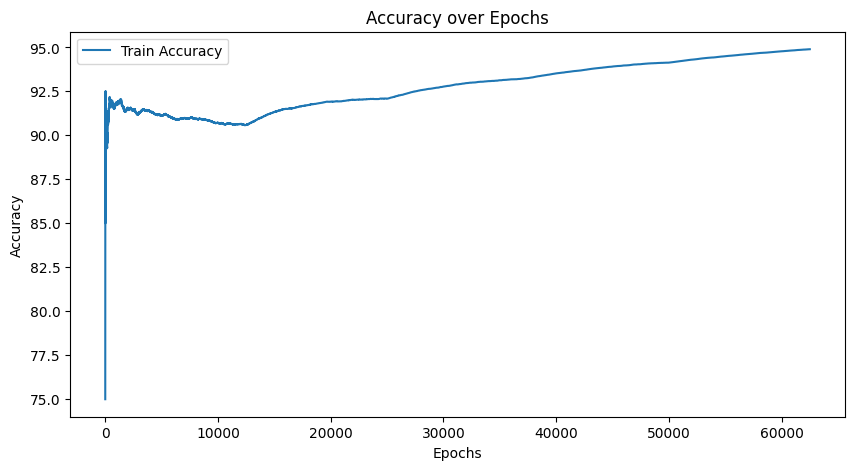

In [ ]:
# Plot initial and post-training sparsity values
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(layer_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, initial_sparsities, width, label='Initial Sparsity')
bars2 = ax.bar(x + width/2, post_training_sparsities, width, label='Post-Training Sparsity')

ax.set_xlabel('Layer')
ax.set_ylabel('Sparsity')
ax.set_title('Sparsity Before and After Training with Regularization')
ax.set_xticks(x)
ax.set_xticklabels(layer_names, rotation=90)
ax.legend()

plt.show()


In [1]:
print(len(train_acc_list))

NameError: name 'train_acc_list' is not defined

In [ ]:
# Measure sparsity after training

# List to store post-training sparsity values
post_training_sparsity_values = []

def get_post_training_activation_sparsity(name):
    def hook(model, input, output):
        total_elements = output.numel()
        zero_elements = (output == 0).sum().item()
        sparsity = zero_elements / total_elements
        post_training_sparsity_values.append((name, sparsity))
    return hook

# Register hooks on the layers
post_training_hooks = []
for name, layer in my_net.named_modules():
    if isinstance(layer, (nn.Conv2d, nn.ReLU, nn.Linear)):
        hook = layer.register_forward_hook(get_post_training_activation_sparsity(name))
        post_training_hooks.append(hook)

# Run a forward pass to measure post-training sparsity
with torch.no_grad():
    _ = my_net(input_tensor)

# Remove hooks after measurement to avoid memory leaks
for hook in post_training_hooks:
    hook.remove()

# Post-training sparsity values
_, post_training_sparsities = zip(*post_training_sparsity_values)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_net.to(device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inp